<a href="https://colab.research.google.com/github/Varhcsa/Train-test/blob/main/fml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [320]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Module for Google Drive
from google.colab import drive

# Module for Importing Images
from PIL import Image 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.10.0+cu111


### Import your drive's contents!

In [321]:
drive.mount('/content/drive')

Mounted at /content/drive


### Let's define some path, and our PokeMon dataset
- Put the "pokemon" folder to somewhere of your Google Drive, and define the train/test path to "train_path" and "test_path"
- To 'model_dir', put the drive's directory path that you want to save your model

In [322]:
train_path = './drive/MyDrive/Dataset/pokemon/train' 
test_path = './drive/MyDrive/Dataset/pokemon/test'
model_dir = './drive/MyDrive/Codes/models'    #./drive/MyDrive/Path/To/Save/Your/Model
classes = ['bug', 'electric', 'fighting', 'fire', 'flying', 'grass', 'ground', 'phychic', 'poison', 'water']

In [323]:
class PokemonDataset(Dataset):
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        # organize path information for __len__ and __getitem__
        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))

         # Add some tranforms for data augmentation.
        self.Flip = torchvision.transforms.RandomHorizontalFlip(p=0.5)
        self.Crop = torchvision.transforms.RandomCrop(90)
        self.Rotat = torchvision.transforms.RandomRotation(45,expand=False)
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
        self.all_transform=torchvision.transforms.Compose([
                              #self.Crop,
                              # self.Flip,
                              #  self.Rotat,
                              #  torchvision.transforms.Resize((120,120)),
                               self.tensor_transform,
                               self.normalize_transform 
                               ])
    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)
        #input = self.all_transform(original_img)
        input = self.all_transform(img)
        sample = dict()
        sample['input'] = input
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

### Set DataSet and DataLoader

In [324]:
batch_size = 64

train_dataset = PokemonDataset(train_path, classes)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = PokemonDataset(test_path, classes)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(classes)

### Take a sample and try to look at the one

In [325]:
sample = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


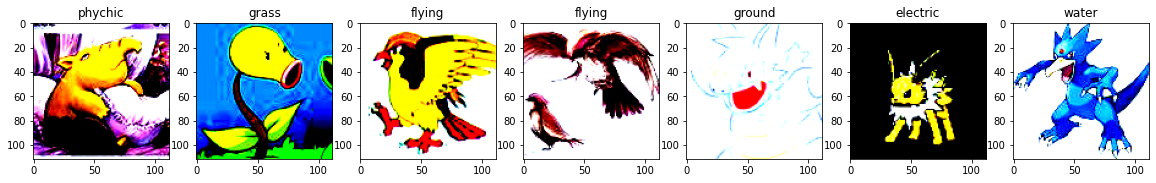

In [326]:
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(7):
    ax[i].imshow(sample['input'][i].permute(1, 2, 0))
    ax[i].set_title(sample['class_name'][i])

### Choose your device - use GPU or not?

In [327]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Define the model with the pre-trained ResNet

In [328]:
class Model(nn.Module):
    def __init__(self, feat_dim = 2048, output_dim =num_classes):
        super(Model, self).__init__()

        self.feat_dim = feat_dim
        self.output_dim = output_dim

        self.backbone = torchvision.models.resnet50(pretrained=True)

        self.backbone.fc = nn.Linear(feat_dim, output_dim)
        ct = 0
        for name, child in self.backbone.named_children():
          ct += 1
          if ct < 3:
            for name2, params in child.named_parameters():
              params.requires_grad = False
    def forward(self, img):
        out = self.backbone(img) 
        return out

### Create a model and its optimizer


In [329]:
model = Model()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-6)

In [330]:
model(sample['input'].to(device)).shape

torch.Size([64, 10])

### Define functions for train/test



In [331]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    input = sample['input'].float().to(device)
    target = sample['target'].long().to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)
    
    top_val, top_idx = torch.topk(pred, 1)

    num_correct = torch.sum(top_idx == target.view(-1, 1))
    
    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [332]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return pred_loss.item(), num_correct.item()

### Run Training

In [333]:
max_epoch = 7
save_stride = 5
tmp_path = './checkpoint.pth'
max_accu = -1
for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    with tqdm(total=len(train_dataloader)) as pbar:
        for idx, sample in enumerate(train_dataloader):
            curr_loss, num_correct = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dataloader)
            train_accu += num_correct / len(train_dataset)
            pbar.update(1)

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model' : Model(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    # Save the checkpoint - you can try to save the "best" model with the validation accuracy/loss
    torch.save(checkpoint, tmp_path)
    if (epoch+1) % save_stride == 0:
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_{}.pth'.format(epoch+1)))
    torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    with tqdm(total=len(test_dataloader)) as pbar:
        for idx, sample in enumerate(test_dataloader):
            curr_loss, num_correct = test(model, sample)
            test_loss += curr_loss / len(test_dataloader)
            test_accu += num_correct / len(test_dataset)
            pbar.update(1)


    max_accu = max(test_accu, max_accu)
    if max_accu == test_accu:
        # Save your best model to the checkpoint
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_best.pth'))

    # These Lines would make you update your Google Drive after the saving.
    drive.flush_and_unmount()
    drive.mount('/content/drive')

    print(train_accu, test_accu)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Mounted at /content/drive
0.7174374204497243 0.7166666666666667


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Mounted at /content/drive
0.9851506151887989 0.75


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Mounted at /content/drive
0.9983029274501481 0.7833333333333333


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Mounted at /content/drive
0.9999999999999997 0.7833333333333333


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Mounted at /content/drive
0.9999999999999997 0.8166666666666667


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Mounted at /content/drive
0.9999999999999997 0.8166666666666667


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Mounted at /content/drive
0.9999999999999997 0.8166666666666667


### Import Packages


In [334]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [335]:
from google.colab import drive
drive.flush_and_unmount()

In [336]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Module for Google Drive
from google.colab import drive

# Module for Importing Images
from PIL import Image 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Make a model.py, and define your model (class) inside the model. 
from model import Model

print(torch.__version__)

1.10.0+cu111


### Import your drive's contents!

In [337]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Let's define our PokeMon dataset
- Put the "pokemon" folder to somewhere of your Google Drive, and define the path to "data_path"

In [338]:
test_path = './drive/MyDrive/Dataset/pokemon/test'
model_dir = './drive/MyDrive/Codes/models'    #./drive/MyDrive/Path/To/Save/Your/Model
classes = ['bug', 'electric', 'fighting', 'fire', 'flying', 'grass', 'ground', 'phychic', 'poison', 'water']

In [339]:
class PokemonDataset(Dataset):
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        # organize path information for __len__ and __getitem__
        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))

        # Add some tranforms for data augmentation.
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)
        input = self.normalize_transform(original_img)

        sample = dict()
        sample['input'] = input
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

### Create dataset/dataloader for test 

In [340]:
test_dataset = PokemonDataset(test_path, classes)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Try to sample out one test dataset

In [341]:
sample = next(iter(test_dataloader))

Text(0.5, 1.0, 'bug')

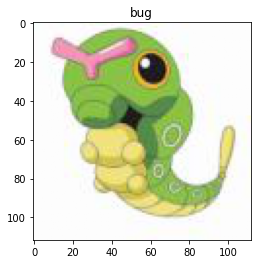

In [342]:
plot_idx = 0
plt.imshow(sample['original_img'][plot_idx].permute(1, 2, 0))
plt.title(sample['class_name'][plot_idx])

### Choose your device - use GPU or not?

In [343]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Load the Saved CheckPoint

In [344]:
# Code referred from: https://discuss.pytorch.org/t/saving-customized-model-architecture/21512/2
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    return model

In [345]:
model_path = './drive/MyDrive/Codes/models/pokemon_r50_recent.pth' 
model = load_checkpoint(model_path)

### Define a function for test

In [346]:
def test(model, sample):
    model.eval()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return num_correct.item()

### Run Test

In [347]:
### Validation Phase
# Initialize Loss and Accuracy
test_accu = 0.0

# Iterate over the val_dataloader
with tqdm(total=len(test_dataloader)) as pbar:
    for idx, sample in enumerate(test_dataloader):
        num_correct = test(model, sample)
        test_accu += num_correct / len(test_dataloader)
        pbar.update(1)

print('Total Accuracy: ', test_accu)

  0%|          | 0/60 [00:00<?, ?it/s]

Total Accuracy:  0.8166666666666675


In [348]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [349]:
from google.colab import drive
drive.flush_and_unmount()